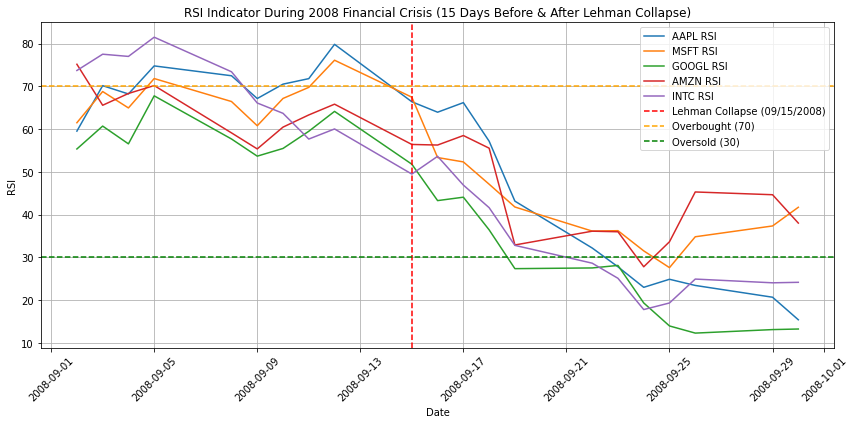

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset (file is named 'Stock_Data.csv')
df_prices = pd.read_csv('Stock_Data.csv')

# Define tech symbols for analysis
tech_symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'INTC']

# Function to calculate RSI
def calculate_rsi(data, window=14):
    data = data.to_numpy().flatten()
    delta = np.diff(data)
    gain = np.maximum(delta, 0)
    loss = -np.minimum(delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    # Prepend NaNs to match the original length
    rsi = np.concatenate(([np.nan] * (window + 1), rsi))
    return rsi[:len(data)]

# Define the crisis window: 15 days before and after Lehman Brothers collapse
crisis_peak_date = pd.to_datetime("2008-09-15")
start_date = crisis_peak_date - pd.Timedelta(days=15)
end_date = crisis_peak_date + pd.Timedelta(days=15)

# Prepare dictionary to store RSI data
rsi_dict = {}

# Calculate RSI for each symbol and filter for the 2008 Financial Crisis window
for symbol in tech_symbols:
    df_symbol = df_prices[df_prices['symbol'] == symbol].copy()
    
    if not df_symbol.empty and 'Close' in df_symbol.columns and 'Date' in df_symbol.columns:
        df_symbol['Date'] = pd.to_datetime(df_symbol['Date'], errors='coerce')
        df_symbol.dropna(subset=['Date', 'Close'], inplace=True)
        df_symbol.sort_values('Date', inplace=True)
        
        # Calculate RSI and ensure it's aligned with the DataFrame
        df_symbol['RSI'] = calculate_rsi(df_symbol['Close'])
        
        # Filter data for the 2008 Financial Crisis window
        df_crisis = df_symbol[(df_symbol['Date'] >= start_date) & (df_symbol['Date'] <= end_date)]
        
        if not df_crisis.empty:
            rsi_dates = df_crisis['Date'].to_numpy().flatten()
            rsi_values = df_crisis['RSI'].to_numpy().flatten()
            
            # Store results in the dictionary
            rsi_dict[symbol] = (rsi_dates, rsi_values)

# Plot RSI for the selected companies during the 2008 Financial Crisis
plt.figure(figsize=(12, 6))

for symbol, (dates, rsi) in rsi_dict.items():
    plt.plot(dates, rsi, label=f'{symbol} RSI')

# Add vertical line for the Lehman Brothers collapse date
plt.axvline(crisis_peak_date, linestyle='--', color='red', label='Lehman Collapse (09/15/2008)')

# Add horizontal lines for overbought and oversold levels
plt.axhline(70, linestyle='--', color='orange', label='Overbought (70)')
plt.axhline(30, linestyle='--', color='green', label='Oversold (30)')

plt.title('RSI Indicator During 2008 Financial Crisis (15 Days Before & After Lehman Collapse)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


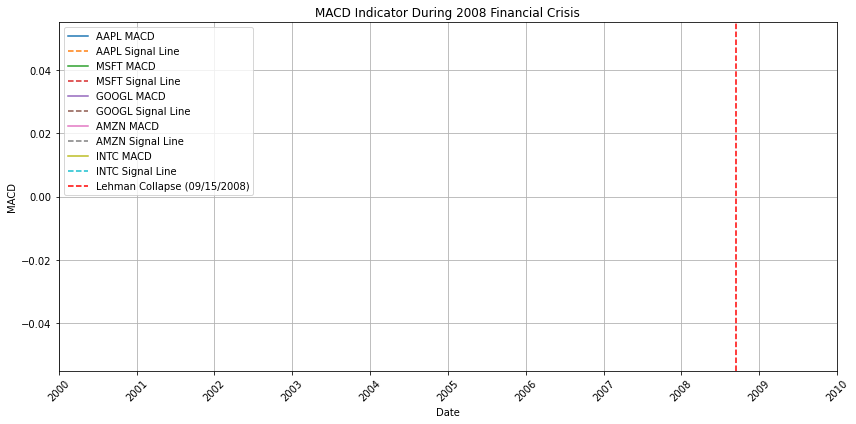

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset (file is named 'Stock_Data.csv')
df_prices = pd.read_csv('Stock_Data.csv')

# Define tech symbols for analysis
tech_symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'INTC']

# Function to calculate MACD using the entire dataset
def calculate_macd(data, slow=26, fast=12, signal=9):
    data = data.values.flatten()
    ema_fast = pd.Series(data).ewm(span=fast, min_periods=1).mean()
    ema_slow = pd.Series(data).ewm(span=slow, min_periods=1).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, min_periods=1).mean()
    return macd, signal_line

# Define the crisis window: 30 days before and 15 days after Lehman Brothers collapse
crisis_peak_date = pd.to_datetime("2008-09-15")
start_date = crisis_peak_date - pd.Timedelta(days=30)
end_date = crisis_peak_date + pd.Timedelta(days=15)

# Prepare dictionary to store MACD data
macd_dict = {}

# Calculate MACD for each symbol using the entire dataset
for symbol in tech_symbols:
    # Filter data for the current symbol
    df_symbol = df_prices[df_prices['symbol'] == symbol].copy()
    
    if not df_symbol.empty and 'Close' in df_symbol.columns and 'Date' in df_symbol.columns:
        # Ensure 'Date' is properly formatted
        df_symbol['Date'] = pd.to_datetime(df_symbol['Date'], errors='coerce')
        df_symbol.dropna(subset=['Date', 'Close'], inplace=True)
        df_symbol.sort_values('Date', inplace=True)
        
        # Calculate MACD using the entire dataset
        df_symbol['MACD'], df_symbol['Signal'] = calculate_macd(df_symbol['Close'])
        
        # Store the entire calculated MACD and Signal line
        macd_dict[symbol] = df_symbol[['Date', 'MACD', 'Signal']]

# Plot only the window for the crisis period
plt.figure(figsize=(12, 6))
for symbol, macd_data in macd_dict.items():
    # Filter the MACD data for the crisis window
    df_crisis = macd_data[(macd_data['Date'] >= start_date) & (macd_data['Date'] <= end_date)]
    
    if not df_crisis.empty:
        plt.plot(df_crisis['Date'].values, df_crisis['MACD'].values, label=f'{symbol} MACD')
        plt.plot(df_crisis['Date'].values, df_crisis['Signal'].values, linestyle='--', label=f'{symbol} Signal Line')

plt.axvline(crisis_peak_date, linestyle='--', color='red', label='Lehman Collapse (09/15/2008)')
plt.title('MACD Indicator During 2008 Financial Crisis')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


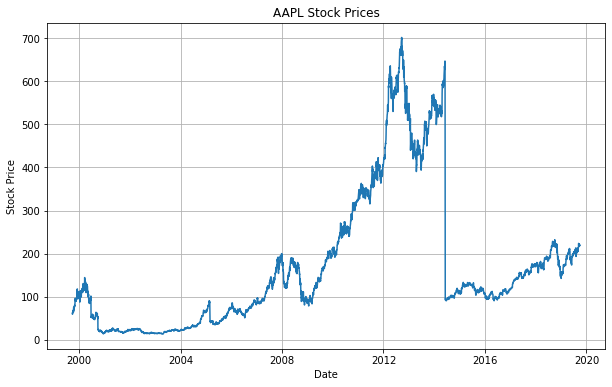

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Load the dataset (Stock_Data.csv)
df_prices = pd.read_csv('Stock_Data.csv')

# Define the tech symbols to analyze
tech_symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'INTC']

# Filter the data for a specific symbol (e.g., AAPL)
symbol = 'AAPL'
df_symbol = df_prices[df_prices['symbol'] == symbol].copy()

# Convert 'Date' column to datetime format
df_symbol['Date'] = pd.to_datetime(df_symbol['Date'], errors='coerce')
df_symbol.dropna(subset=['Date', 'Close'], inplace=True)
df_symbol.set_index('Date', inplace=True)
df_symbol.sort_index(inplace=True)

# Ensure there are no missing values in the 'Close' column
df_symbol['Close'].fillna(method='ffill', inplace=True)

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(df_symbol['Close'])
plt.title(f'{symbol} Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()


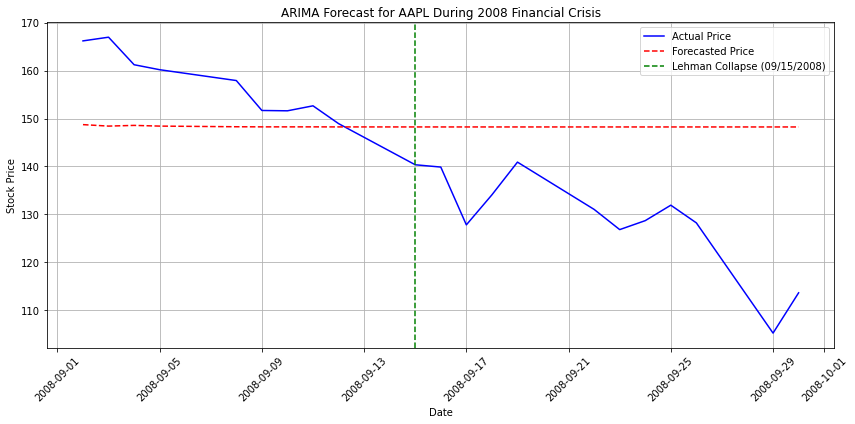

Mean Squared Error for AAPL: 320.50



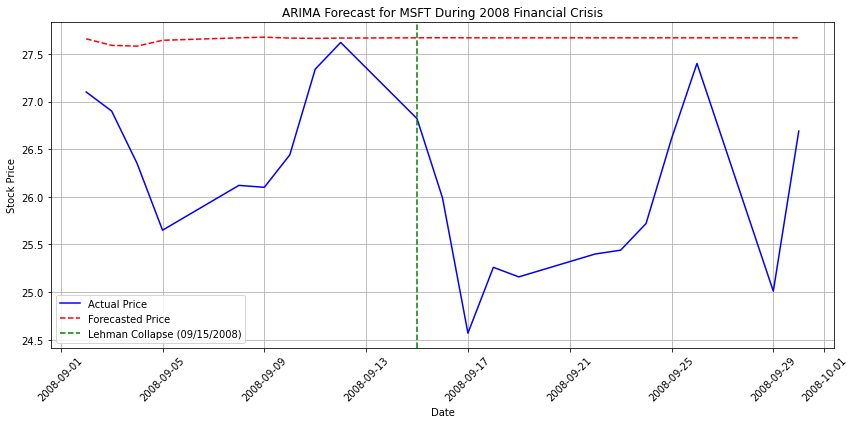

Mean Squared Error for MSFT: 2.91



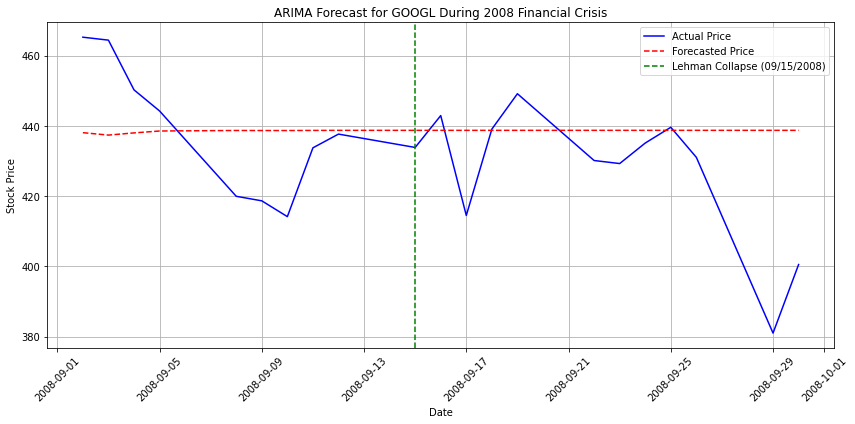

Mean Squared Error for GOOGL: 418.94



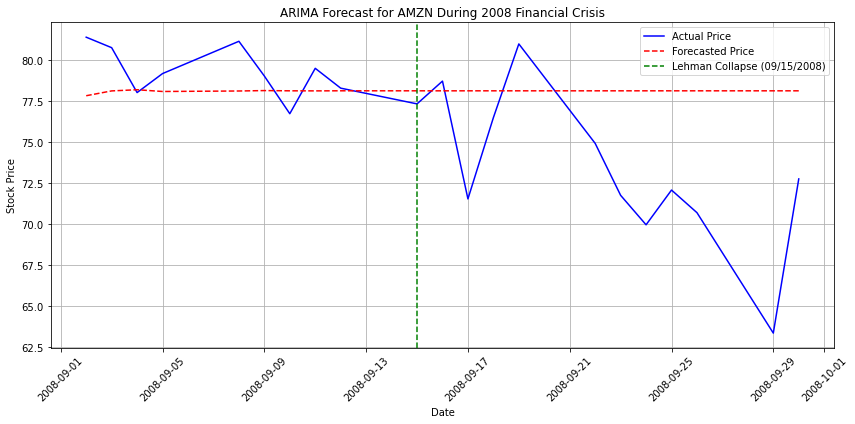

Mean Squared Error for AMZN: 26.08



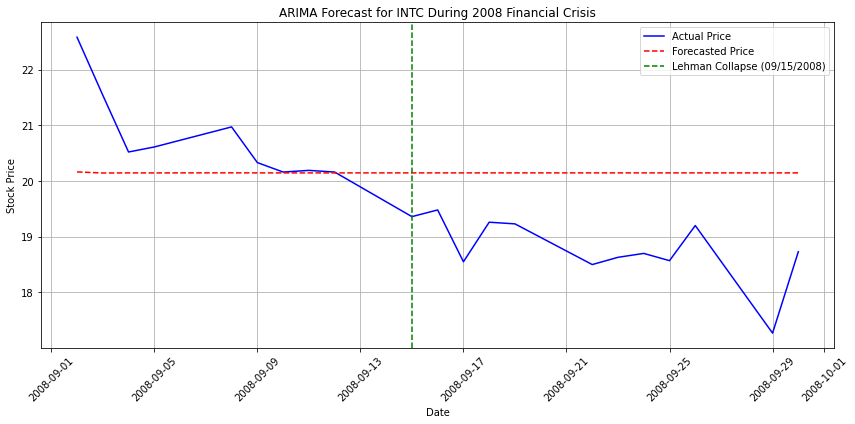

Mean Squared Error for INTC: 1.66



In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Load the dataset (Stock_Data.csv)
df_prices = pd.read_csv('Stock_Data.csv')

# Define tech symbols for analysis
tech_symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'INTC']

# Define the crisis peak date and the time window
crisis_peak_date = pd.to_datetime("2008-09-15")
start_date = crisis_peak_date - pd.Timedelta(days=15)
end_date = crisis_peak_date + pd.Timedelta(days=15)

# Function to train the ARIMA model and plot for the crisis period
def plot_arima_for_crisis(symbol, df):
    # Filter data for the specific symbol
    df_symbol = df[df['symbol'] == symbol].copy()
    
    if df_symbol.empty or 'Close' not in df_symbol.columns or 'Date' not in df_symbol.columns:
        print(f"No data available for {symbol}")
        return

    # Prepare the data
    df_symbol['Date'] = pd.to_datetime(df_symbol['Date'], errors='coerce')
    df_symbol.dropna(subset=['Date', 'Close'], inplace=True)
    df_symbol.set_index('Date', inplace=True)
    df_symbol.sort_index(inplace=True)
    df_symbol['Close'].fillna(method='ffill', inplace=True)

    # Ensure we have enough data
    if df_symbol.index.max() < end_date or df_symbol.index.min() > start_date:
        print(f"Insufficient data for the crisis period for {symbol}")
        return

    # Split the data into train and crisis period
    train_data = df_symbol[df_symbol.index < crisis_peak_date]['Close']
    test_data = df_symbol[(df_symbol.index >= start_date) & (df_symbol.index <= end_date)]['Close']

    # Fit the ARIMA model on the training data
    model = ARIMA(train_data, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast for the crisis window
    n_steps = len(test_data)
    forecast = model_fit.forecast(steps=n_steps)

    # Convert test_data and forecast to numpy arrays
    test_dates = test_data.index.values
    test_values = test_data.values
    forecast_values = forecast.values

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, test_values, label='Actual Price', color='blue')
    plt.plot(test_dates, forecast_values, label='Forecasted Price', linestyle='--', color='red')
    plt.axvline(crisis_peak_date, linestyle='--', color='green', label='Lehman Collapse (09/15/2008)')
    plt.title(f'ARIMA Forecast for {symbol} During 2008 Financial Crisis')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(test_values, forecast_values)
    print(f'Mean Squared Error for {symbol}: {mse:.2f}\n')

# Run the ARIMA model for each tech company
for symbol in tech_symbols:
    plot_arima_for_crisis(symbol, df_prices)


Epoch 1/2
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 5.9425e-04
Epoch 2/2
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 1.0884e-04
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


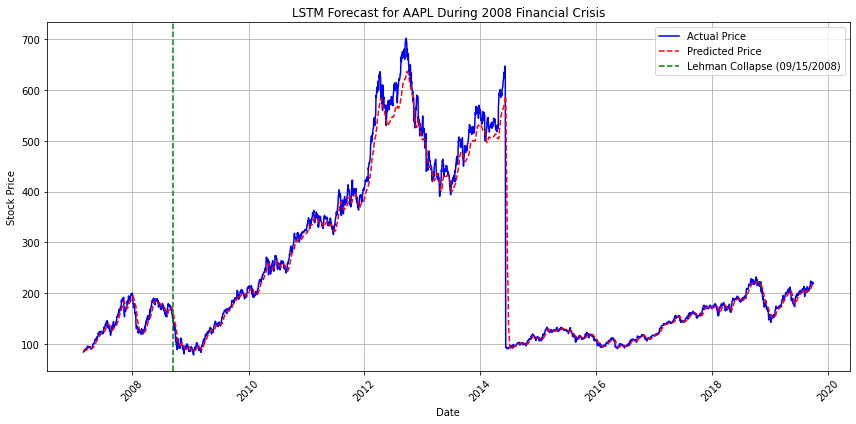

Mean Squared Error for AAPL: 693.56


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

# Load the dataset (Stock_Data.csv)
df_prices = pd.read_csv('Stock_Data.csv')

# Define the tech symbols to analyze
symbol = 'AAPL'  # Change this symbol for other companies if needed

# Prepare the date range for the 2008 financial crisis
crisis_peak_date = pd.to_datetime("2008-09-15")
start_date = crisis_peak_date - pd.Timedelta(days=15)
end_date = crisis_peak_date + pd.Timedelta(days=15)

# Filter data for the selected symbol
df_symbol = df_prices[df_prices['symbol'] == symbol].copy()
df_symbol['Date'] = pd.to_datetime(df_symbol['Date'], errors='coerce')
df_symbol.dropna(subset=['Date', 'Close'], inplace=True)
df_symbol.set_index('Date', inplace=True)
df_symbol.sort_index(inplace=True)
df_symbol['Close'].fillna(method='ffill', inplace=True)

# Ensure we have sufficient data
if df_symbol.empty:
    print(f"No data available for {symbol}")
    exit()

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_symbol[['Close']].to_numpy().reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])  # Correct indexing
        y.append(data[i, 0])               # Correct indexing
    return np.array(x), np.array(y)

sequence_length = 60
x, y = create_sequences(scaled_data, sequence_length)

# Split data into train and test sets (training before 2008-09-15)
train_size = int(len(df_symbol[df_symbol.index < crisis_peak_date]) * 0.8)
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

# Reshape input for LSTM [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=2, batch_size=32)

# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Inverse transform actual values
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Prepare the dates for plotting
test_dates = df_symbol.index[-len(y_test):].to_numpy()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_scaled.flatten(), label='Actual Price', color='blue')
plt.plot(test_dates, predictions.flatten(), label='Predicted Price', linestyle='--', color='red')
plt.axvline(crisis_peak_date, linestyle='--', color='green', label='Lehman Collapse (09/15/2008)')
plt.title(f'LSTM Forecast for {symbol} During 2008 Financial Crisis')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_scaled.flatten(), predictions.flatten())
print(f'Mean Squared Error for {symbol}: {mse:.2f}')
